#### **Polina V1.0.15**

**Credit Scoring**

Прогнозирование вероятности дефолта заемщика

Представьте, что вы работаете стажером в отделении регионального банка. Вы все также делаете запросы к базам данных и строите отчеты. Вы поймали себя на мысли, что представляли работу дата-саентиста совсем иначе…

И вот сегодня, когда вы уже были на пороге отчаяния, ваш начальник пришел к вам с долгожданной новостью. Будем строить модель!

“Отлично,” – думаете вы, – “наконец-то смогу заняться настоящей работой!”

Вашей задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

Условия соревнования:
Данное соревнование является бессрочным и доступно для всех потоков.

Срок выполнения соревнования устанавливается индивидуально в каждом потоке.

Тестовая выборка представлена в ЛидерБорде целиком.

Поэтому лучшие и победные решения буду проверяться на их "адекватность" (чтоб не было подгонки под тестовую выборку).

Разрешено использовать любые ML алгоритмы и библиотеки (кроме DL).

Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

Credit Scoring
Прогнозирование вероятности дефолта заемщика

In [1]:
import pandas as pd
import numpy as np
from pandas import Series
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, plot_confusion_matrix, accuracy_score, recall_score, precision_score


%matplotlib inline

In [ ]:
class task4():
    def __init__(self):
        self.df_train
        self.df_test
        self.data 
        return
    
    def load_df(df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        self.df_train['sample'] = 1 # помечаем где у нас трейн
        self.df_test['sample'] = 0 # помечаем где у нас тест
        self.df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать,
                      # по этому пока просто заполняем нулями

        self.data = self.df_test.append(df_train, sort=False).reset_index(drop=True)
        return

# Собираем вместе train, test с пометкой sample

In [48]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')

In [49]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать,
                      # по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)

# data = df_train.copy()

# Обработка пропусков

In [463]:
#визуализация пропусков
# fig, ax = plt.subplots(figsize=(20,12))
# sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [464]:
# data.isnull().sum()

In [50]:
def preproc_education_na_df_change_to_mode(df):
    # fill null in education
    most_common = df['education'].mode()
    df['education'].fillna(most_common[0], inplace=True)
    return df


def preproc_education_na_df_delete(df):
    df.dropna(axis=0, inplace=True)
    return df

In [45]:
# пропуски только в education, удаляем
# data.dropna(axis=0, inplace=True)

# заменяем пропуски в education на самое частое значение
data = preproc_education_na_df_change_to_mode(data)

KeyError: 'education'

# Рассмотрение числовых, бинарных и категориальных признаков

In [467]:
data.sample(4)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
85351,80486,28MAR2014,SCH,F,53,Y,N,0,0,-2.245739,1,50,2,3,5500,1,1,N,1,0
74218,3341,09JAN2014,SCH,F,41,N,N,1,0,-0.354616,3,60,2,3,18500,1,3,N,1,1
90650,76738,24MAR2014,GRD,M,44,N,N,0,0,-2.631163,6,80,2,3,25000,2,2,N,1,0
52448,50317,27FEB2014,SCH,F,40,N,N,0,0,-1.326812,1,50,1,2,16000,2,3,N,1,0


In [51]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport' ]
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

In [52]:
"""Проверяет, совпадает ли множество категорий в тестовой и учебной выборках"""


def check_categories_in_dfs(c_cols, b_cols):    
    err=0
    for col in c_cols:
        if data[col].nunique() != df_test[col].nunique():
            print(col, data[col].unique(), 'vs.', df_test[col].unique())
            err += 1
    for col in b_cols:
        if data[col].nunique() != df_test[col].nunique():
            print(col, data[col].unique(), 'vs.', df_test[col].unique())
            err += 1
    if err==0:
        print('Категории в учебной и тестовой выборках идентичны')

In [53]:
check_categories_in_dfs(cat_cols, bin_cols)

Категории в учебной и тестовой выборках идентичны


# Генерируем новые признаки

In [9]:
# давность подачи заявки в днях
data['days_to_app'] = (pd.to_datetime(datetime.now()) 
                       - pd.to_datetime(data['app_date'])).apply(lambda x: x.days)
min_val = data['days_to_app'].min()
data['days_to_app'] = data['days_to_app'].apply(lambda x: x-min_val)
# месяц подачи заявки
data['month_app'] = pd.to_datetime(data['app_date']).apply(lambda x: x.month)

In [11]:
data['days_to_app'].min(), data['days_to_app'].max()

(0, 119)

В датасете представлены данные за 120 дней
Это данные за 4 месяца - с января по апрель

In [12]:
data['month_app'].value_counts()

3    31597
2    27097
4    26266
1    25188
Name: month_app, dtype: int64

In [13]:
if 'days_to_app' not in num_cols:
    num_cols.append('days_to_app')


if 'month_app' not in cat_cols:
    cat_cols.append('month_app')
        
num_cols , cat_cols

(['age',
  'decline_app_cnt',
  'score_bki',
  'bki_request_cnt',
  'income',
  'days_to_app'],
 ['education',
  'region_rating',
  'home_address',
  'work_address',
  'sna',
  'first_time',
  'month_app'])

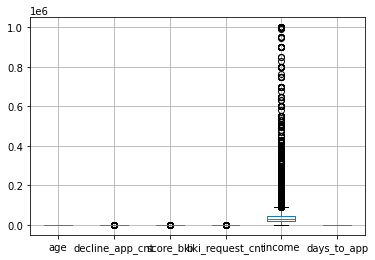

In [14]:
data[num_cols].boxplot()

In [15]:
def has_outliers(column, df=data):

    q25, q75 = np.percentile(df[column], [25, 75], axis=0)
    iqr = q75-q25
    lower_bound = q25 - 1.5*iqr
    upper_bound = q75 + 1.5*iqr
    
#     print('---------------------------')
#     print('Границы выбросов: ', lower_bound, ', ', upper_bound)
#     print('---------------------------')

    ok_values_cnt = (df[column].loc[df[column].between(
        lower_bound, upper_bound)]).count()
    outliers_cnt = df[column].count() - ok_values_cnt

    print('Количество выбросов', outliers_cnt)
    print('---------------------------')

In [16]:
for col in num_cols:
    print(col.upper())
    has_outliers(col)
    print(col.upper(), 'LOG')
    has_outliers(col, np.log1p(data[num_cols]))

AGE
Количество выбросов 0
---------------------------
AGE LOG
Количество выбросов 0
---------------------------
DECLINE_APP_CNT
Количество выбросов 18677
---------------------------
DECLINE_APP_CNT LOG
Количество выбросов 18677
---------------------------
SCORE_BKI
Количество выбросов 518
---------------------------
SCORE_BKI LOG
Количество выбросов 4450
---------------------------
BKI_REQUEST_CNT
Количество выбросов 2636
---------------------------
BKI_REQUEST_CNT LOG
Количество выбросов 15
---------------------------
INCOME
Количество выбросов 7000
---------------------------
INCOME LOG
Количество выбросов 2609
---------------------------
DAYS_TO_APP
Количество выбросов 0
---------------------------
DAYS_TO_APP LOG
Количество выбросов 4127
---------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


In [17]:
def lookup_on_num_column(df, col_name):
    plt.figure(figsize=(6,4))
    
    sns.distplot(df[col_name], kde = False, rug=False)
    
    plt.show()
    #sns.histplot(data=df[col_name])
    sns.distplot(np.log1p(df[col_name]), kde = False, rug=False)



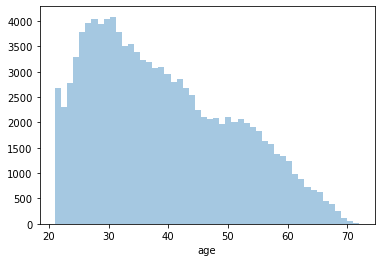

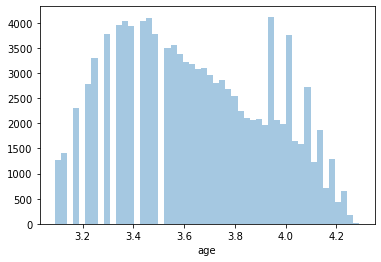

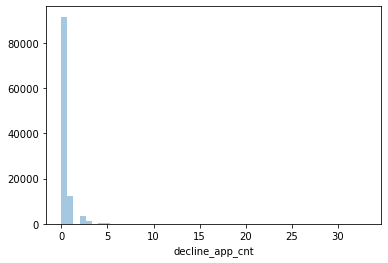

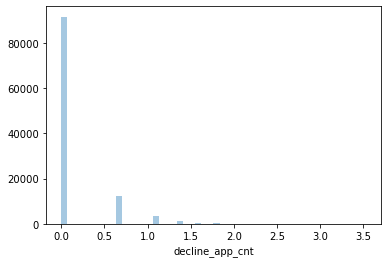

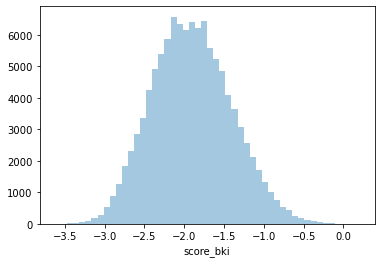

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


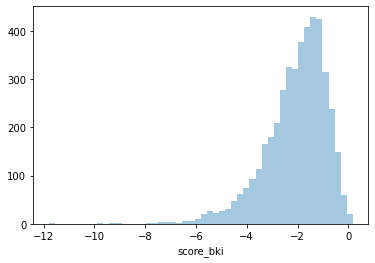

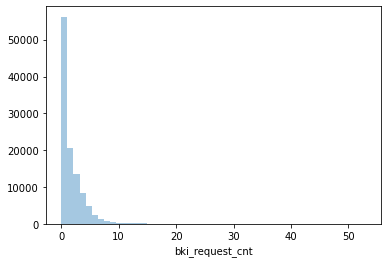

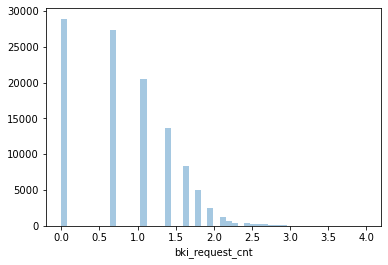

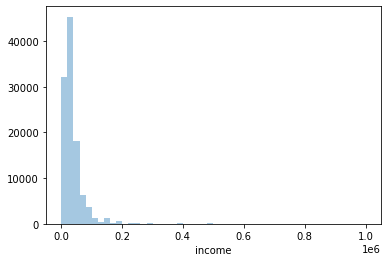

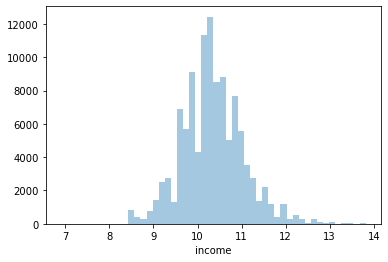

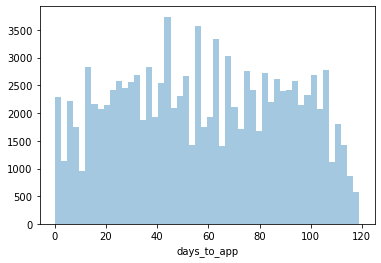

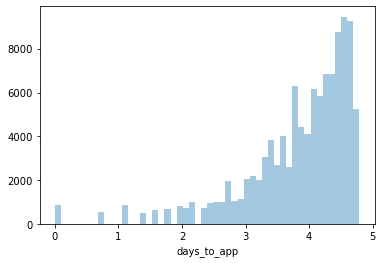

In [18]:
for col in num_cols:
    lookup_on_num_column(data, col)

## **Выводы о распределениях  по графикам:**

age - скорее лог-нормальное, признак логарифмируем

decline_app_cnt - почти все значения сосредоточены в нуле, распределение скорее лог-нормальное, выбросов меньше, когда признак логарифмируем, так и поступим

score_bki - нормальное распределение, выбросов не много

bki_request_cnt - скорее лог-нормальное, признак логарифмируем

income - лог-нормальное, выбросов много, пока все оставляем, признак логарифмируем

days_to_app - скорее равномерное с учетом "сезонных" колебаний


# Логарифмируем выбранные числовые признаки

In [519]:
cols_to_log1p = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
data[cols_to_log1p].apply(lambda x: np.log1p(x))

,age,decline_app_cnt,bki_request_cnt,income
0,3.401197,0.000000,1.386294,10.819798
1,3.688879,1.791759,1.098612,8.517393
2,3.931826,0.000000,0.693147,10.308986
3,4.043051,0.000000,0.693147,9.741027
4,3.663562,0.000000,0.000000,11.695255
...,...,...,...,...
110143,3.828641,0.000000,1.386294,9.741027
110144,3.737670,0.000000,0.693147,11.156265
110145,3.465736,0.000000,1.609438,10.714440
110146,3.401197,0.000000,1.386294,9.472782


In [20]:
def find_lower_upper_bound(column, df):
    q25, q75 = np.percentile(df[column], [25, 75], axis=0)
    iqr = q75-q25
    lower_bound = q25 - 1.5*iqr
    upper_bound = q75 + 1.5*iqr
    return lower_bound, upper_bound

'''return new df without outliers in column'''


def del_outliers_for_column(column, lower_b, upper_b, df):

    df_no_outliers = df.loc[df[column].between(lower_b, upper_b)]
    
    return df_no_outliers

cols_to_del_outliers = ['score_bki', 'bki_request_cnt', 'income']

lb_score, ub_score = find_lower_upper_bound('score_bki', data)
lb_bki_request_cnt, ub_bki_request_cnt = find_lower_upper_bound('bki_request_cnt', data)
lb_income, ub_income = find_lower_upper_bound('income', data)

print(data.shape)
data = del_outliers_for_column('score_bki', lb_score, ub_score, data)
data = del_outliers_for_column('bki_request_cnt', lb_bki_request_cnt, ub_bki_request_cnt, data)
data = del_outliers_for_column('income', lb_income, ub_income, data)

print(data.shape)




(110148, 22)
(100482, 22)


пробуем удалить выбросы

# Посмотрим интересные истории распределения с учетом целевого default

In [21]:
def boxplot_for_numcols(df, col_name, hue_col=None):
    plt.figure()
    # sns.boxplot(x=df[hue_col], y=np.log1p(np.abs(df[col_name])))
    sns.boxplot(x=df[hue_col], y=df[col_name])

    plt.show

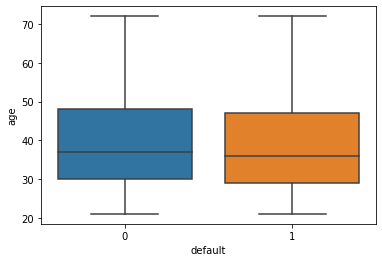

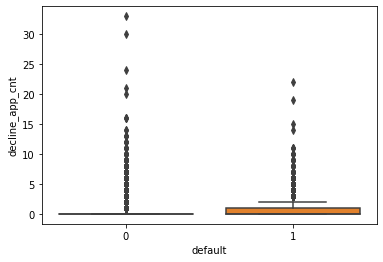

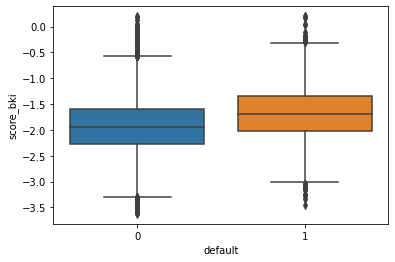

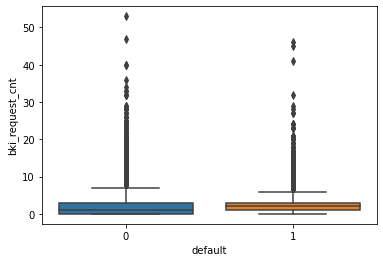

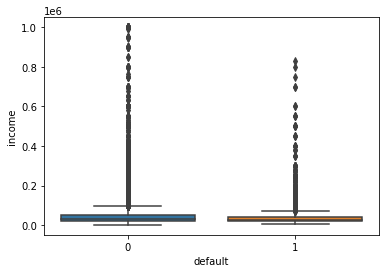

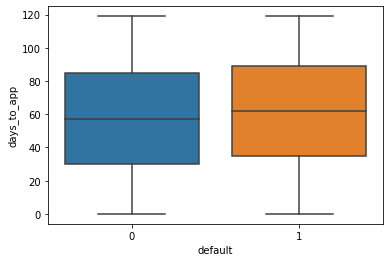

In [482]:
for column in num_cols:
    boxplot_for_numcols(data, column, 'default')

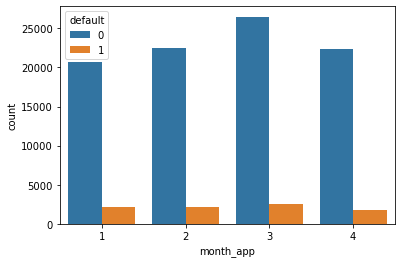

In [22]:
sns.countplot(x='month_app', data=data, hue='default')

судя по распределнию 

## выводы о наблюдениях

средний возраст дефолта меньше, чем недефолта

значение skore_bki выше у дефолта, чем у недефолта 

bki_request_cnt больше у дефолта чем у недефолта

days_to_app (давность подачи заявки) больше у недефолта

In [23]:
data.where(data['decline_app_cnt']==0).groupby(by='default')['decline_app_cnt'].sum()

default
0.0    0.0
1.0    0.0
Name: decline_app_cnt, dtype: float64

In [24]:
data.where(data['decline_app_cnt']>0).groupby(by='default')['decline_app_cnt'].sum()

default
0.0    22101.0
1.0     4129.0
Name: decline_app_cnt, dtype: float64

In [486]:
data.groupby('default')['income'].median()

default
0    30000
1    28000
Name: income, dtype: int64

# Корреляция между числовыми признаками

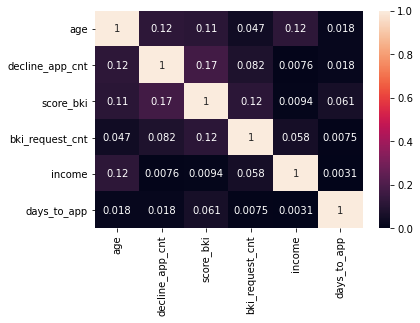

In [25]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

##  Вывод про корреляцию
Видим, что абсолютные значения корреляции не большие (макс - 0.19) - т.е признаки можем считать независимыми, и добавлять их в модель все

0.17 - после удаления выбросов в признаках income, score_bki, bki_request_cnt

# Построение ANOVA-f метрики для оценки значимости числовых признаков

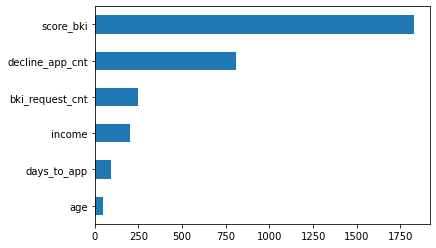

In [26]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Работа с бинарными признаками - перекодировка в числовые (0, 1)

In [27]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [28]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,days_to_app,month_app
63945,100633,17APR2014,UGR,0,30,0,0,0,0,-1.505022,...,2,3,25000,4,2,0,1,0,13,4
78800,99722,16APR2014,UGR,0,51,1,0,0,0,-2.202970,...,2,3,40000,1,2,0,1,0,14,4
18865,85792,02APR2014,GRD,0,32,1,0,0,0,-2.111239,...,1,3,12500,1,3,1,0,0,28,4
70807,6494,13JAN2014,GRD,1,35,1,0,0,0,-1.966995,...,1,2,40000,3,3,0,1,0,107,1
26032,89196,05APR2014,SCH,1,46,0,0,0,0,-2.036865,...,2,3,15000,2,3,0,0,0,25,4


### Категориальные признаки тоже надо сделать числовыми

In [29]:
cat_cols

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'month_app']

In [30]:
print(data['education'].unique())
data['education'] = label_encoder.fit_transform(data['education'])
print(dict(enumerate(label_encoder.classes_)))

['GRD' 'SCH' 'UGR' 'PGR' 'ACD']
{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


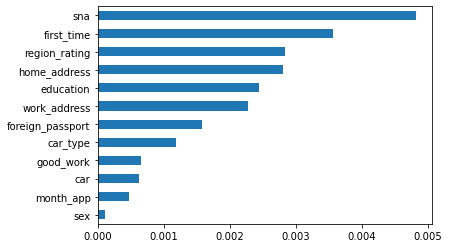

In [493]:
imp_cat = Series(mutual_info_classif(
    data[bin_cols + cat_cols], data['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [494]:
# fig = px.parallel_coordinates(data, dimensions=['decline_app_cnt',
#         'default'], color='default')
# fig.show()

In [495]:
# fig = px.parallel_coordinates(data, dimensions=['sna',
#         'default'], color='default')
# fig.show()

## One-hot encoding для категориальных переменных

In [496]:
# для тренировочной выборки
# data_tr_cat = data[data['sample']==1][cat_cols]
# data_tr_cat
# X_tr_cat = OneHotEncoder(sparse = False).fit_transform(data_tr_cat.values)
# X_tr_cat.shape


# для тестовой выборки
# data_test_cat = data[data['sample']==0][cat_cols]
# data_test_cat
# X_test_cat = OneHotEncoder(sparse = False).fit_transform(data_test_cat.values)
# X_test_cat.shape

In [497]:
# data_copy = data.copy()
# print('copy done')

In [31]:
# для объединенной выборки делаем get_dummies для всех категориальных переменных
print(data.shape)
cols_to_dummies = cat_cols
data = pd.get_dummies(data, columns=cols_to_dummies)
data.shape

(100482, 22)


(100482, 45)

In [499]:

# X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
# X_cat.shape

# Собираем вместе все преобразованные части датасета

###### числовые - 
###### категориальные - преобразованы в числовые, сделан one-hot (dummies)
###### бинарные



# тут могла быть общая функция обработки данных

In [56]:
def proc_data(df, bin_cols, cat_cols, num_cols):
    
    #---избавляемся от NAN
    df = preproc_education_na_df_change_to_mode(df)
    #data = preproc_education_na_df_deleteproc(data)
    #---------------------
    bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport' ]
    cat_cols = ['education', 'region_rating', 'home_address', 
                'work_address', 'sna', 'first_time']
    num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

    #---добавили новые признаки---
    # давность подачи заявки в днях
    df['days_to_app'] = (pd.to_datetime(datetime.now()) 
                         - pd.to_datetime(df['app_date'])).apply(lambda x: x.days)
    min_val = df['days_to_app'].min()
    df['days_to_app'] = df['days_to_app'].apply(lambda x: x-min_val)
    # месяц подачи заявки
    data['month_app'] = pd.to_datetime(data['app_date']).apply(lambda x: x.month)
    if 'days_to_app' not in num_cols:
        num_cols.append('days_to_app')
        
    if 'month_app' not in cat_cols:
        cat_cols.append('month_app')
    #----------------------

    
    #---прологарифмировали некоторые признаки
    cols_to_log1p = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
    data[cols_to_log1p].apply(lambda x: np.log1p(x))
    #-----------------
    
    #---бинарные - в числовые
    label_encoder = LabelEncoder()
    for column in bin_cols:
        df[column] = label_encoder.fit_transform(df[column])
    #---строковые категориальные в числовые    
    df['education'] = label_encoder.fit_transform(df['education'])
    df['region_rating'] = label_encoder.fit_transform(df['region_rating'])


    #---dummies для категорильных
    cols_to_dummies = cat_cols
    df = pd.get_dummies(df, columns=cols_to_dummies)


    #---удаление ненужных признаков 
    df.drop('client_id', axis=1, inplace=True)
    df.drop('app_date', axis=1, inplace=True)
    
    return df, bin_cols, cat_cols, num_cols

# Разбиваем выборку на учебную и тестовую

In [32]:
# Удалям признаки, которые преобразовали, рассмотрели, и они не войдут в модель:
# client_id, app_date

# data.drop('client_id', axis=1, inplace=True)
# data.drop('app_date', axis=1, inplace=True)




In [33]:
"""делает из df массив, где вначале записаны 
числовые данные, дальше бинарные, потом категориальные
такой порядок нужен, чтоб удобно применять StandardScaler
df должен быть без признаков default, sample"""

def combine_df_in_ndarray(df, n_cols, b_cols):
    #print(len(num_cols), num_cols)
    #print(len(bin_cols), bin_cols)
    #print(len(cat_cols), cat_cols)
    
    #print(num_cols+bin_cols)
    other_cols = df.columns.to_list()
    #print('other_cols')
    #print(other_cols)

    for x in n_cols+b_cols:
    #    print(x)
        other_cols.remove(x)
    
    #print(len(df.columns)-len(num_cols)-len(bin_cols), len(other_cols))
    #print(other_cols)
    
        
    X = np.hstack([df[n_cols].values, df[b_cols].values, df[other_cols].values])
    #print(X.shape)
    return X
    

In [ ]:
def create_orig_test_from_preproced_df(df, num_columns, bin_columns):
    # выделенеи TEST, которые были из файла test.csv
    test_data_df = df.query('sample == 0').drop(['sample'], axis=1)
    test_data_df.drop('default', axis=1, inplace=True)
    X_test_ORIG = combine_df_in_ndarray(test_data_df, num_columns, bin_columns)
    return X_test_ORIG

In [ ]:
def create_train_splited_on4(df, num_columns, bin_columns):
    # Выделяем TRAIN выборку
    train_data_df = df.query('sample == 1').drop(['sample'], axis=1)


    # Обработка TRAIN
    # убираем столбцы default
    X_df = train_data_df.drop(['default'], axis=1)

    # теперь готовим массив данных из df, чтоб было возможно применять Scaler - 
    # упорчдочим столбцы (сначала числовые, потом бинарные, потому дамми от категориальных)
    X = combine_df_in_ndarray(X_df, num_columns, bin_columns)
    y = train_data_df['default'].values            # наш таргет


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test

In [57]:
def create_train_splited_on4_balanced_by_def1(df, num_columns, bin_columns):
    ## experiment cut def=0 to size def=1
    # Делим выборку назад на учебную и тестовую, согласно признаку sample
    train_data_df_EX = df.query('sample == 1').drop(['sample'], axis=1)


    size1 = len(train_data_df_EX[train_data_df_EX['default']==1])
    rez0 = train_data_df_EX[train_data_df_EX['default']==0][:size1]
    rez1 = train_data_df_EX[train_data_df_EX['default']==1]
    rezX = rez0.append(rez1)


    # убираем столбцы default
    X_df_EX = rezX.drop(['default'], axis=1)

    # теперь готовим массив данных из df, чтоб было возможно применять Scaler - 
    # упорчдочим столбцы (сначала числовые, потом бинарные, потому дамми от категориальных)
    X_EX = combine_df_in_ndarray(X_df_EX, num_columns, bin_columns)
    y_EX = rezX['default'].values 


    X_train, X_test, y_train, y_test = train_test_split(X_EX, y_EX, test_size=0.20, 
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

In [58]:
def create_train_splited_on4_balanced_by_def0(df, num_columns, bin_columns):
    # experiment добавим несклько раз дубли для default=1
    # Делим выборку назад на учебную и тестовую, согласно признаку sample
    train_data_df_EX2 = df.query('sample == 1').drop(['sample'], axis=1)

    rez1 = train_data_df_EX[train_data_df_EX['default']==1]
    train_data_df_EX2 = train_data_df_EX2.append(rez1)

    train_data_df_EX2 = train_data_df_EX2.append(rez1)

    # убираем столбцы default
    X_df_EX2 = train_data_df_EX2.drop(['default'], axis=1)

    # теперь готовим массив данных из df, чтоб было возможно применять Scaler - 
    # упорчдочим столбцы (сначала числовые, потом бинарные, потому дамми от категориальных)
    X_EX2 = combine_df_in_ndarray(X_df_EX2, num_columns, bin_columns)
    y_EX2 = train_data_df_EX2['default'].values 


    X_train, X_test, y_train, y_test = train_test_split(X_EX2, y_EX2, test_size=0.20, 
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

9372


In [34]:
# выделенеи TEST, которые были из файла test.csv
# test_data_df = data.query('sample == 0').drop(['sample'], axis=1)
# test_data_df.drop('default', axis=1, inplace=True)
# X_test_ORIG = combine_df_in_ndarray(test_data_df, num_cols, bin_cols)

In [35]:
# Выделяем TRAIN выборку
# train_data_df = data.query('sample == 1').drop(['sample'], axis=1)


# # Обработка TRAIN
# # убираем столбцы default
# X_df = train_data_df.drop(['default'], axis=1)

# # теперь готовим массив данных из df, чтоб было возможно применять Scaler - 
# # упорчдочим столбцы (сначала числовые, потом бинарные, потому дамми от категориальных)
# X = combine_df_in_ndarray(X_df, num_cols, bin_cols)
# y = train_data_df['default'].values            # наш таргет




# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [432]:
## experiment cut def=0 to size def=1
# Делим выборку назад на учебную и тестовую, согласно признаку sample
# train_data_df_EX = data.query('sample == 1').drop(['sample'], axis=1)


# size1 = 9372
# rez0 = train_data_df_EX[train_data_df_EX['default']==0][:size1]
# rez1 = train_data_df_EX[train_data_df_EX['default']==1]
# rezX = rez0.append(rez1)


# # убираем столбцы default
# X_df_EX = rezX.drop(['default'], axis=1)

# # теперь готовим массив данных из df, чтоб было возможно применять Scaler - 
# # упорчдочим столбцы (сначала числовые, потом бинарные, потому дамми от категориальных)
# X_EX = combine_df_in_ndarray(X_df_EX, num_cols, bin_cols)
# y_EX = rezX['default'].values 


# X_train, X_test, y_train, y_test = train_test_split(X_EX, y_EX, test_size=0.20, random_state=42)

In [448]:
# experiment добавим несклько раз дубли для default=1
# Делим выборку назад на учебную и тестовую, согласно признаку sample
# train_data_df_EX2 = data.query('sample == 1').drop(['sample'], axis=1)

# rez1 = train_data_df_EX[train_data_df_EX['default']==1]
# train_data_df_EX2 = train_data_df_EX2.append(rez1)

# train_data_df_EX2 = train_data_df_EX2.append(rez1)

# # убираем столбцы default
# X_df_EX2 = train_data_df_EX2.drop(['default'], axis=1)

# # теперь готовим массив данных из df, чтоб было возможно применять Scaler - 
# # упорчдочим столбцы (сначала числовые, потом бинарные, потому дамми от категориальных)
# X_EX2 = combine_df_in_ndarray(X_df_EX2, num_cols, bin_cols)
# y_EX2 = train_data_df_EX2['default'].values 


# X_train, X_test, y_train, y_test = train_test_split(X_EX2, y_EX2, test_size=0.20, random_state=42)

## Стандартизуем числовые признаки: отдельно тренировочной, отдельно тестовой выборок

In [59]:
def scale_numeric_data(X_train, X_test1, X_test2, num_col_cnt):
    scaler = StandardScaler()

    X_train[:,:num_col_cnt] = scaler.fit_transform(X_train[:,:num_col_cnt]).copy()

    X_test1[:,:num_col_cnt] = scaler.transform(X_test[:,:num_col_cnt])
    X_test2[:,:num_col_cnt] = scaler.transform(X_test_ORIG[:,:num_col_cnt])
    return X_train, X_test1, X_test2

In [ ]:
l = len(num_cols)
X_train, X_test, X_test_ORIG = scale_numeric_data(X_train, X_test, X_test_ORIG)

In [36]:
# l = len(num_cols)
 
# scaler = StandardScaler()

# X_train[:,:l] = scaler.fit_transform(X_train[:,:l]).copy()

# X_test[:,:l] = scaler.transform(X_test[:,:l])

# X_test_ORIG[:,:l] = scaler.transform(X_test_ORIG[:,:l])

In [37]:
model = LogisticRegression( max_iter=300)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [62]:
def print_metrics(model, X_test, y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    Sp = tn / (tn+fp)
    # Se = tp / (tp+fn)
    # Re = tp / (tp+fn)
    # Pr = tp / (tp+fp)
    # Ac = (tn+tp) / (tp+tn+fp+fn)
    # print('Acc=%.4f.  Pr=%.4f.  Re=%.4f.  Se=%.4f.  Sp=%.4f' % (Ac , Pr , Re , Se , Sp))
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('Precision: %.4f' % precision_score(y_test, y_pred))
    print('Recall: %.4f' % recall_score(y_test, y_pred))
    print('Specifity: %.4f' % Sp)
    print('F1: %.4f' % f1_score(y_test, y_pred))
    print('tn fp fn tp: ', tn, fp, fn, tp)
    plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
    plt.show()
    roc_auc = print_roc_auc(model, X_test, y_test)
    print('roc_auc: ', roc_auc)
    return

In [38]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Sp = tn / (tn+fp)
# Se = tp / (tp+fn)
# Re = tp / (tp+fn)
# Pr = tp / (tp+fp)
# Ac = (tn+tp) / (tp+tn+fp+fn)
# print('Acc=%.4f.  Pr=%.4f.  Re=%.4f.  Se=%.4f.  Sp=%.4f' % (Ac , Pr , Re , Se , Sp))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('Specifity: %.4f' % Sp)
print('F1: %.4f' % f1_score(y_test, y_pred))


Accuracy: 0.8706
Precision: 0.5000
Recall: 0.0235
Specifity: 0.9965
F1: 0.0450


удалили выбросы

Accuracy: 0.8706
Precision: 0.5000
Recall: 0.0235
Specifity: 0.9965
F1: 0.0450

conf_matrix: array([11684,    41,  1701,    41])

roc_auc  0.731



# Весь флоу

In [ ]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')

# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать,
                      # по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)

data, bin_cols, cat_cols, num_cols = proc_data(data, bin_cols, cat_cols, num_cols)

X_test_ORIG = create_orig_test_from_preproced_df(data, num_cols, bin_cols)

X_train, X_test, y_train, y_test = create_train_splited_on4(data, num_cols, bin_cols)

l = len(num_cols)
scale_numeric_data(X_train, X_test, X_test_ORIG, l)

model = LogisticRegression( max_iter=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print_metrics(model, X_test, y_test, y_pred)


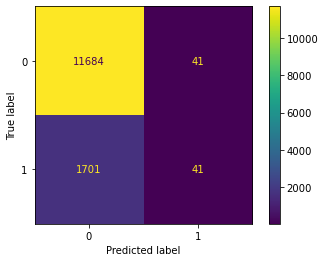

In [40]:
# plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
# plt.show()

In [41]:
confusion_matrix(y_test, y_pred).ravel()

array([11684,    41,  1701,    41])

# ROC-AUC

In [42]:
#построение  ROC 
def print_roc_auc(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    probs = probs[:,1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    return roc_auc

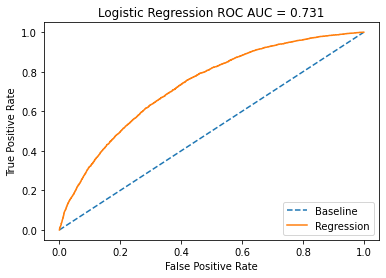

In [454]:
print_roc_auc(model, X_test, y_test)

## Промежуточный вывод

хоть Roc-auc имеет хорошее значение, confusion-матрица плохая - мы часто даем кредит тем, кто в итоге его не погасит (FN = 1788)

In [43]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 
# и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении


model = LogisticRegression(random_state=42)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)

best_model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = best_model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: None
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'lbfgs'
	tol: 0.0001
	verbose: 0
	warm_start: False
Accuracy: 0.6693
Precision: 0.2290
Recall: 0.6573
F1: 0.3396


Получили best_model, пострим для нее roc-auc, confusion-matrix

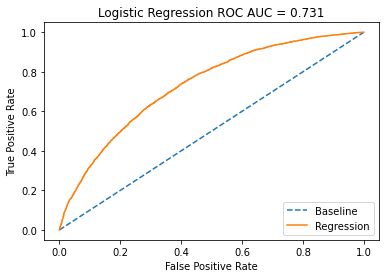

In [456]:
print_roc_auc(best_model, X_test, y_test)

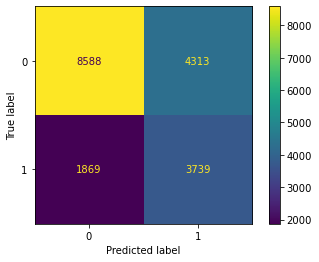

In [457]:
plot_confusion_matrix(best_model, X_test, y_test)

# Выводы о полученной улучшенной модели после подбора гиперпараметров с условием, что хотим максимизировать f1-скоринг

модель стала чаще отказывать надежным плательщикам - было 68 (FP) - 12865(TN), стало 4254 - 8679


модель лучше распознает "дефолтных" -было 39 (TP) - 1788(FN), стало 1243 - 584

# SUBMISSION

In [458]:
best_model

LogisticRegression(class_weight='balanced', max_iter=50, random_state=42,
                   tol=0.001)

In [ ]:
#X_test = test_data.drop(['default'], axis=1)


# тут массив из данных из файла test, который обрабатывался так же, как и train, 
# над ним сделалася StandardScaler.transform() по Scalerу, 
# который настроился на тренировночных данных.
print(X_test_ORIG.shape)

y_pred_prob_FINAL = best_model.predict_proba(X_test_ORIG)[:,1]


data_test = pd.read_csv(DATA_DIR+'/test.csv')
submit = pd.DataFrame(data_test['client_id'])
submit['default'] = y_pred_prob_FINAL

submit.head(20)


# СОЗДАНИЕ ФАЙЛА САБМИТА
submit.to_csv('submission.csv', index=False)